In [50]:
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import END, StateGraph, START
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal, List
from typing_extensions import TypedDict
from dotenv import load_dotenv
import uuid
import os
from pprint import pprint

In [9]:
load_dotenv()

True

In [10]:
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
# os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [11]:
llm = ChatGroq(model=os.getenv("LLM_MODEL", "llama-3.1-8b-instant"), api_key=groq_api_key)
embeddings_model = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
llm2 = ChatGroq(model=os.getenv("LLM_MODEL", "llama3-70b-8192"), api_key=groq_api_key)

In [61]:
# gemma2-9b-it

vectorstore = FAISS.load_local("/workspaces/CRAG-with-CRAWAI-WEB-SCRAPPING/faiss_index", embeddings_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [58]:
docs = retriever.invoke("Hi my name is Govin")
print(docs)

[Document(id='5a612a88-4d60-4d06-a4e4-323fefac8323', metadata={'title': 'Contact Genie Business for Home-Based Business Inquiries', 'summary': 'To learn more about home-based businesses, fill out the form on this page or reach out via call or email. Genie Business aims to respond to all inquiries within 24 hours on business days.', 'url': 'https://www.geniebusiness.lk/home-based-business.php'}, page_content='the form below and we will contact you. We endeavor to answer all inquiries within 24 hours on business days. \n[ Call](https://www.geniebusiness.lk/<tel:+94760760760>) Email\nName\nEmail\nPhone Number\nMessage\nSubmit\n[ ![](https://www.geniebusiness.lk/media/callemail.png) ](https://www.geniebusiness.lk/<#contact-pop>)'), Document(id='2706f1d7-ef78-43de-b4ac-36068df735d4', metadata={'title': 'Pricing - Genie Business', 'summary': 'View the pricing information for Genie Business services. Contact them via call or email for inquiries, which will be answered within 24 hours on busin

RAG CHAIN

In [15]:
system = """You are a customer service assistant for 'Genie Business' called 'Ashen' for question-answering tasks. \n
You are always giving answers to a merchant who is looking to get information. \n
Use the following pieces of retrieved context to answer the question. \n
If you don't know the answer, just say that you don't know. \n
Use simpler and keep the answer short but detailed and answer concise."""

agent_promt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Answer the question {question} with the context {context}"),
    ]
)
rag_chain = agent_promt | llm | StrOutputParser()

In [16]:
question = "Hi my name is Govin"
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Hello Govin, I'm Ashen from Genie Business. How can I assist you today?


Graded document class

In [17]:
class Grade(BaseModel):
    """Binary score for relevance"""

    binary_score: Literal["Yes", "No"] = Field(description="Useful score 'Yes' or 'No'")

LLM with structured output

In [18]:
structured_llm_grader = llm2.with_structured_output(Grade)

system = """You are an expert at grading and assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Retrieved document: \n\n {document} \n\n User question: {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [19]:
question = "What is genie business"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/tmp/ipykernel_48757/2712839225.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='Yes'


In [20]:
question = "tell me about the Tajmahal."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='No'


Question re-writer

In [21]:
system = """You an expert question re-writer that converts an input question to a better version that is optimized for web search. \n
Look at the input and try to reason about the underlying semantic intent / meaning \n
Reply only with the new question \n
"""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Here is the initial question: \n\n {question} \n Formulate an improved question.")
    ]
)

question_rewriter = rewrite_prompt | llm2 | StrOutputParser()

In [22]:
question_rewriter.invoke({"question": question})

'What is the history and significance of the Taj Mahal in India?'

In [24]:
system = """You are a grader assessing whether an answer is grounded in / supported by a set of facts containing in the documment. \n 
Give a binary score 'Yes' or 'No' to indicate whether the answer is grounded in / supported by a set of facts."""

gen_v_doc_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Heres the document: \n\n {document} \n\n Here is the answer : {generation}")
    ]
)

generation_v_document_grader = gen_v_doc_prompt | structured_llm_grader

In [26]:
generation = "My name is Ashen"
docs = "Ashen is my name"
print(generation_v_document_grader.invoke({"document": docs, "generation":generation}))

binary_score='Yes'


In [28]:
system = """You are a grader assessing whether an answer is useful to resolve a question. \n 
Look at the question and answer and try to reason whether the answer resolves the question or not. \n
Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question."""

gen_v_ques_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","Heres the question: \n\n {question} \n\n Here is the answer : {generation}")
    ]
)
generation_v_question_grader = gen_v_ques_prompt | structured_llm_grader

In [30]:
generation = "My name is Ashen"
question = "What is your name"
print(generation_v_question_grader.invoke({"question": question, "generation":generation}))

binary_score='Yes'


Create state class to manage state in the graph

In [31]:
class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [ ]:
class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: str
    generation: str
    web_search: str
    documents: List[str]

Create required functions

In [62]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    question = state["question"]
    documents = retriever.invoke(question)

    return {"documents":documents, "question":question}

In [69]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")

    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []

    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score

        if grade == 'Yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d.page_content)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    return {"documents":filtered_docs, "question":question}

In [35]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")

    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context":documents, "question":question})

    return {"documents":documents, "question":question, "generation":generation}

In [36]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    
    documents = state["documents"]

    better_question = question_rewriter.invoke({"question":question})

    return {"documents":documents, "question":better_question}

In [37]:
def prepare_for_final_grade(state):
    """
    Stage for final grade, passthrough state.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        state (dict): The current state of the agent, including all keys.
    """
    print("---FINAL GRADE---")

    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    return {"documents":documents, "question":question, "generation":generation} 

In [38]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, filtered_documents, that contains relevant documents.
    """
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        #re-generate a new query
        print("---DECISION: TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


In [52]:
def grade_generation_v_documents(state):
    """
    Determines whether the generation is grounded in the document.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision score.
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = generation_v_document_grader.invoke({"document":documents, "generation":generation})
    if score.binary_score == "Yes":
        print("---DECISION: SUPPORTED, MOVE TO FINAL GRADE---")
        return "supported"
    else:
        print("---DECISION: NOT SUPPORTED, GENERATE AGAIN---")
        return "not supported"

In [40]:
def grade_generation_v_question(state):
    """
    Determines whether the generation addresses the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision score.
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = generation_v_question_grader.invoke({"question":question, "generation":generation})
    if score.binary_score == "Yes":
        print("---DECISION: USEFUL---")
        return "useful"
    else:
        print("---DECISION: NOT USEFUL---")
        return "not useful"

Graph

In [ ]:
workflow = StateGraph(State)

#Define nodes
workflow.add_node("retrieve",retrieve)
workflow.add_node("grade_documents",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("transform_query",transform_query)
workflow.add_node("prepare_for_final_grade",prepare_for_final_grade)

#Building the graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve","grade_documents")
workflow.add_conditional_edges("grade_documents",decide_to_generate,
                               {"transform_query":"transform_query",
                                "generate":"generate"}
                                )
workflow.add_edge("transform_query","retrieve")
workflow.add_conditional_edges("generate",grade_generation_v_documents,
                               {"supported":"prepare_for_final_grade",
                                "not supported":"generate"}
                               )
workflow.add_conditional_edges("prepare_for_final_grade",grade_generation_v_question,
                               {"useful":END,
                                "not useful":"generate"}
                                )
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

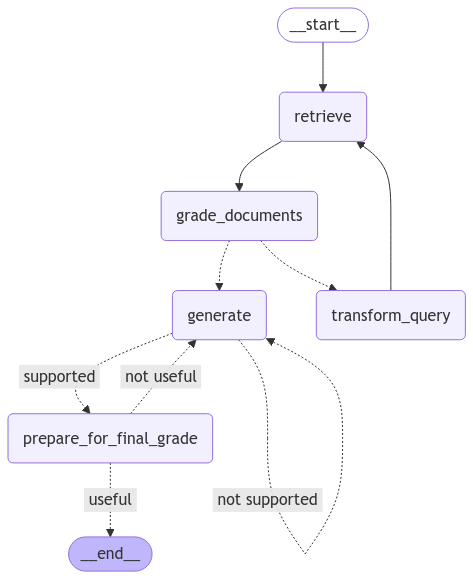

In [73]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [74]:
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        "thread_id": thread_id
    }
}

In [75]:
inputs = {"question": "What is Genie Business."}
for output in app.stream(inputs, config=config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
"Node 'generate':"
'\n---\n'
---FINAL GRADE---
---DECISION: USEFUL---
"Node 'prepare_for_final_grade':"
'\n---\n'
('Genie Business is an all-in-one fintech business solution in Sri Lanka that '
 'simplifies receiving payments through various methods, including QR codes, '
 'tap to pay, and payment links. It offers working capital services, an '
 'Internet Payment Gateway (IPG), Multi-Currency Pricing (MCP), and an '
 "E-Store, catering to the diverse needs of today's businesses.")


In [76]:
inputs = {"question": "What services do you offer?"}
for output in app.stream(inputs, config=config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
"Node 'generate':"
'\n---\n'
---FINAL GRADE---
---DECISION: USEFUL---
"Node 'prepare_for_final_grade':"
'\n---\n'
('We offer a variety of services to help businesses grow and succeed. Some of '
 'our key services include:\n'
 '\n'
 '1. **Easy and Versatile Payment Solutions**: We provide Tap to Pay, QR Code '
 'Payments, Payment Links, and Internet Payment Gateway (IPG) to simplify '
 'transactions and increase customer satisfaction.\n'
 '2. **Working Capital Services**: Our flexible working capital solutions help '
 'businesses fuel their growth and overcome financial challenges.\n'
 '3. **Multi-Currency Pricing (MCP)**: This feature allows businesses to '
 'accept payments in various curre

In [77]:
inputs = {"question": "I have business which have a website as well as a retail store what payment solutions are ideal for me?"}
for output in app.stream(inputs, config=config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
"Node 'generate':"
'\n---\n'
---FINAL GRADE---
---DECISION: USEFUL---
"Node 'prepare_for_final_grade':"
'\n---\n'
('Considering you have a business with both a website and a retail store, the '
 'ideal payment solutions for you would be:\n'
 '\n'
 '1. **Payment Links**: This allows customers to make secure, remote '
 'transactions by sending payment links through email or messaging apps.\n'
 '2. **QR Code Payments**: This enables customers to make fast, secure, and '
 'convenient payments using their smartphones by scanning QR codes.\n'
 '3. **Internet Payment Gateway (IPG)**: This facilitates online transactions, '
 'supporting the e-commerce needs of your modern business.\n'
 '4. **E-store

In [80]:
inputs = {"question": "How does pricing looks like for this ?"}
for output in app.stream(inputs, config=config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---


---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
"Node 'generate':"
'\n---\n'
---FINAL GRADE---
---DECISION: USEFUL---
"Node 'prepare_for_final_grade':"
'\n---\n'
('The pricing for Genie Business is as follows:\n'
 '\n'
 '- Tap-to-Pay: 2.75%\n'
 '- LQR: 1.00%\n'
 '- Int QR: 1.80%\n'
 '- E-Store: 2.75% or 3.00%\n'
 '- Payment Links: 2.75% or 3.00%\n'
 '- IPG: 2.75% or 3.00%\n'
 '- MCP (Multi-Currency Pricing): 2.75%')


In [81]:
inputs = {"question": "I can't understand it can you explain it further ?"}
for output in app.stream(inputs, config=config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
"Node 'generate':"
'\n---\n'
---FINAL GRADE---
---DECISION: USEFUL---
"Node 'prepare_for_final_grade':"
'\n---\n'
("I'd be happy to explain the information about Genie Business in simpler "
 'terms.\n'
 '\n'
 "You wanted me to explain something, but I'm not sure what specific part of "
 'the information you were having trouble understanding. Would you like me to '
 'explain something in particular, such as how multi-currency pricing works or '
 'how to use the Genie Business platform?')
